# Implementing Partial Convolution
----
Based on: https://github.com/MathiasGruber/PConv-Keras/blob/master/notebooks/Step2%20-%20Partial%20Convolution%20Layer.ipynb

Converted into pytorch from keras

In [1]:
import torch
from PIL import Image
from torchvision import transforms
from mask_generator import *
from partialconv2d import *
import numpy as np

## Testing

### Load data

In [2]:
# Torchvision transform
T = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

# Load image
img = T(Image.open(r'/tmp/imagenette2/train/n03394916/ILSVRC2012_val_00041668.JPEG'))
print(f"Image tensor size: {img.size() , img.dtype}")

# Generate mask
img_mask = MaskGenerator(256, 256).sample(5)
print(f"Mask tensor size: {img_mask.size(), img_mask.dtype}")

# Image + mask
masked_img = img * img_mask
print(f"Masked image size: {masked_img.size(), masked_img.dtype}")

Image tensor size: (torch.Size([3, 256, 256]), torch.float32)
Mask tensor size: (torch.Size([256, 256]), torch.uint8)
Masked image size: (torch.Size([3, 256, 256]), torch.float32)


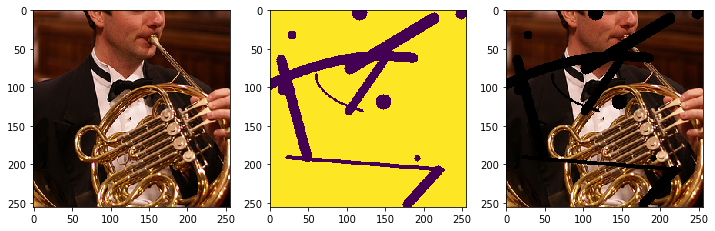

In [3]:
_, axes = plt.subplots(1,3, figsize=(12,4))

axes[0].imshow(img.permute(1,2,0).numpy())
axes[1].imshow(img_mask.numpy() * 255)
axes[2].imshow(masked_img.permute(1,2,0).numpy())

## Test output of the partial convolution layers

In [4]:
from partialconv2d import *

pc = PartialConv2d(64, 128, kernel_size=7, stride=1).to('cuda')
pc.get_output_shape(256, 256, 5)

torch.Size([5, 128, 256, 256])

## Test the partial convolution layers

Just a several layers of partial_conv2d, while saving all the outputs for the validation of the layer.

In [5]:
pc1 = PartialConv2d(3, 8, kernel_size=(7,7), stride=(2,2)).to('cuda')
pc2 = PartialConv2d(8, 16, kernel_size=(5,5), stride=(2,2)).to('cuda')
pc3 = PartialConv2d(16, 32, kernel_size=(3,3), stride=(2,2)).to('cuda')
pc4 = PartialConv2d(32, 64, kernel_size=(3,3), stride=(2,2)).to('cuda')

In [6]:
out_img1 = pc1(img.expand(1,-1,-1,-1), img_mask.type_as(img).expand(1,1,-1,-1))
print(f"out_img1: {out_img1.size(), out_img1.dtype}")
print(f"out_mask1: {pc1.mask_out.size(), pc1.mask_out.dtype}")

out_img1: (torch.Size([1, 8, 128, 128]), torch.float32)
out_mask1: (torch.Size([1, 8, 128, 128]), torch.float32)


In [7]:
out_img2 = pc2(out_img1, pc1.mask_out)
print(f"out_img2: {out_img2.size(), out_img2.dtype}")
print(f"out_mask2: {pc2.mask_out.size(), pc2.mask_out.dtype}")

out_img2: (torch.Size([1, 16, 64, 64]), torch.float32)
out_mask2: (torch.Size([1, 16, 64, 64]), torch.float32)


In [9]:
out_img3 = pc3(out_img2, pc2.mask_out)
print(f"out_img3: {out_img3.size(), out_img3.dtype}")
print(f"out_mask3: {pc3.mask_out.size(), pc3.mask_out.dtype}")

out_img3: (torch.Size([1, 32, 32, 32]), torch.float32)
out_mask3: (torch.Size([1, 32, 32, 32]), torch.float32)


In [10]:
out_img4 = pc4(out_img3, pc3.mask_out)
print(f"out_img4: {out_img4.size(), out_img4.dtype}")
print(f"out_mask4: {pc4.mask_out.size(), pc4.mask_out.dtype}")

out_img4: (torch.Size([1, 64, 16, 16]), torch.float32)
out_mask4: (torch.Size([1, 64, 16, 16]), torch.float32)


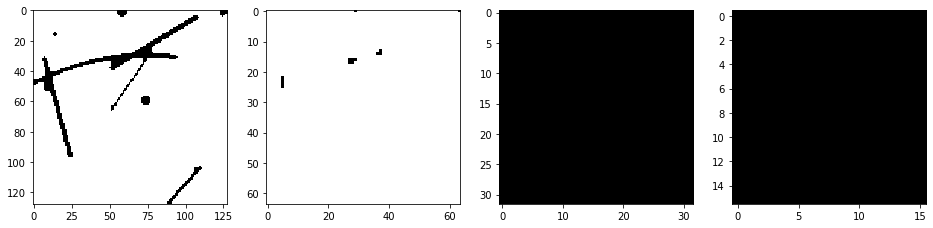

In [12]:
_, axes = plt.subplots(1,4,figsize=(16,4))
axes[0].imshow(pc1.mask_out.cpu().numpy()[0,np.random.choice(pc1.mask_out.shape[1], 1)[0],:,:], cmap=plt.cm.gray)
axes[1].imshow(pc2.mask_out.cpu().numpy()[0,np.random.choice(pc2.mask_out.shape[1], 1)[0],:,:], cmap=plt.cm.gray)
axes[2].imshow(pc3.mask_out.cpu().numpy()[0,np.random.choice(pc3.mask_out.shape[1], 1)[0],:,:], cmap=plt.cm.gray)
axes[3].imshow(pc4.mask_out.cpu().numpy()[0,np.random.choice(pc4.mask_out.shape[1], 1)[0],:,:], cmap=plt.cm.gray)

In [13]:
pc4.mask_out.cpu().numpy()[0,0,:,:]

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,

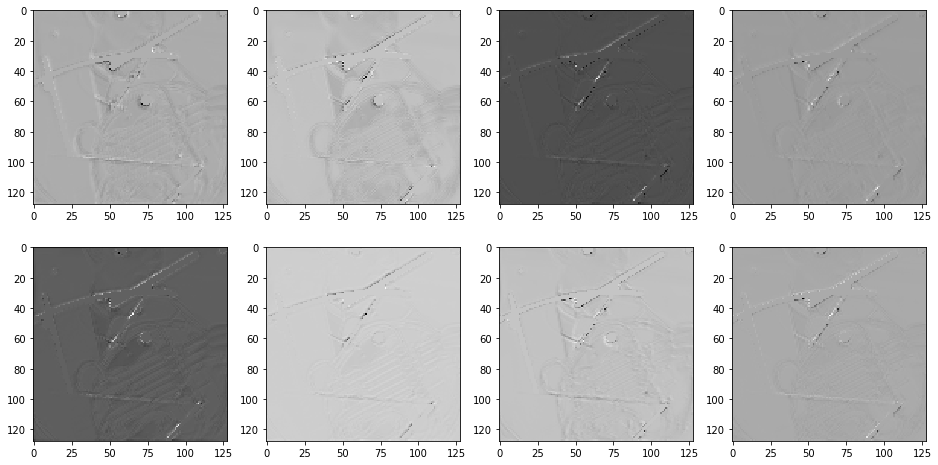

In [15]:
_, axes = plt.subplots(2,4,figsize=(16,8))
axes = axes.flatten()

for i in range(out_img1.shape[1]):
    axes[i].imshow(out_img1.detach().cpu().numpy()[0,i,:,:], cmap=plt.cm.gray)